In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

import random
import gradio as gr

In [2]:
load_dotenv()

True

In [3]:
nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [4]:
def shout(text: Annotated[str, "A string to shout out loud"]) -> str:
    """Shout out loud"""
    return text.upper() + "!!!"

shout("hello")

'HELLO!!!'

In [5]:
# 1.Define State object
class State(BaseModel):

    messages: Annotated[list, add_messages]

In [6]:
# 2.Build the graph
graph_builder = StateGraph(State) # Graph builder notes down the Annotations to understand where to merge

In [7]:
# 3. Define the nodes
def our_first_node(old_state: State) -> State:

    reply = f"Hello! I am a {random.choice(adjectives)} {random.choice(nouns)}. What's your name?"
    messages = [{'role': 'assistant', 'content': reply}]

    new_state = State(messages=messages) # Graph build will merge the old_state and new_state
    return new_state

graph_builder.add_node("first_node", our_first_node)

In [8]:
# 4. Define the edges
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

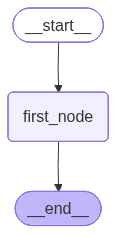

In [9]:
# 5. Compile the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)

    # 6. Turn the wheel
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content #each message is an object NOT dict, so access with dot notation

gr.ChatInterface(fn=chat, title="LangGraph Test").launch()

/mnt/d/Work/Projects/AI-Engineer/medical-reports/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:348: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='s', additional_kwargs={}, response_metadata={}, id='ac08074b-62e3-4e2c-b8d8-83599ab8a07c'), AIMessage(content="Hello! I am a untrustworthy Unicorns. What's your name?", additional_kwargs={}, response_metadata={}, id='aebf2d17-9782-4e21-a0c9-f4cf82d2909a')]}


In [18]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [21]:
llm = ChatOpenAI(model="gpt-4o-mini")

def llm_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    messages = [response]
    new_state = State(messages=messages)
    return new_state

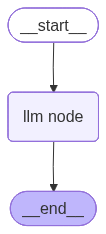

In [22]:
graph_builder.add_node("llm node", llm_node)
graph_builder.add_edge(START, "llm node")
graph_builder.add_edge("llm node", END)
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
def chat(user_message, history):
    messages = [{"role": "user", "content": user_message}]
    state = State(messages=messages)
    new_state = graph.invoke(state)
    return new_state["messages"][-1].content

In [ ]:
gr.ChatInterface(fn=chat, title="LangGraph LLM Test").launch()
# messages list is reset with every new state
# the point of add_messages is to keep the messages list growing with each node

/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the exchange rate of EUR to BDT now?")

'Convert Bangladeshi Taka to Euro ; 1 BDT, 0.00703383 EUR ; 5 BDT, 0.0351691 EUR ; 10 BDT, 0.0703383 EUR ; 25 BDT, 0.175846 EUR. EUR to BDT exchange rates today ; 1 EUR, 142.94 BDT ; 5 EUR, 714.69 BDT ; 10 EUR, 1,429.37 BDT ; 20 EUR, 2,858.74 BDT. FX: 1.00 EUR – 143.5339 BDT Exchange Rates and Fees shown are estimates, vary by a number of factors including payment and payout methods, and are subject ... Euros to Bangladeshi Takas today · 1.0000 EUR = 141.9833 BDT · 1 Euro to Bangladeshi Taka historical data. FX: 1.00 EUR – 142.6880 BDT Exchange Rates and Fees shown are estimates, vary by a number of factors including payment and payout methods, and are subject ... Conversion rate table for different amounts ; 1 EUR. 137.47 BDT ; 10 EUR. 1374.72 BDT ; 20 EUR. 2749.45 BDT ; 100 EUR. 13747.24 BDT. Euros to Bangladeshi Takas: exchange rates today ; 20 BDT, 0.13 EUR ; 50 BDT, 0.34 EUR ; 100 BDT, 0.69 EUR ; 250 BDT, 1.74 EUR. Learn the current Euro to Bangladeshi Taka exchange rate and the c

In [40]:
from langchain.agents import Tool

tool_search = Tool(
    name = "web_search",
    func=serper.run,
    description="Useful for when you need to do a web search"
)

In [41]:
tool_search.invoke("What is the exchange rate of 1 EUR to BDT now?")

"Convert Euro to Bangladeshi Taka ; 1 EUR, 141.788 BDT ; 5 EUR, 708.942 BDT ; 10 EUR, 1,417.88 BDT ; 25 EUR, 3,544.71 BDT. EUR to BDT exchange rates today ; 1 EUR, 143.03 BDT ; 5 EUR, 715.14 BDT ; 10 EUR, 1,430.28 BDT ; 20 EUR, 2,860.56 BDT. 1 EUR = 142.1208 BDT · 1. Check out our exchange rates · 2. Add money to your account · 3. Pay with your card in Europe. Conversion rate table for different amounts ; 1 EUR. 137.47 BDT ; 10 EUR. 1374.72 BDT ; 20 EUR. 2749.45 BDT ; 100 EUR. 13747.24 BDT. FX: 1.00 EUR – 143.5339 BDT Exchange Rates and Fees shown are estimates, vary by a number of factors including payment and payout methods, and are subject ... The exchange rate for Euro to Bangladeshi takas is currently 142.191 today, reflecting a 0.223% change since yesterday. Over the past week, the value of Euro ... Conversion rates. Euro / Bangladeshi Taka ; 1 EUR142.36054 BDT ; 2 EUR284.72108 BDT ; 5 EUR711.80270 BDT ; 10 EUR1,423.60539 BDT ; 100 EUR14,236.05393 BDT. Conversion rate table for d

In [42]:
from rich.console import Console
console = Console()

def push_notification(message):
    console.log(f"[bold green]{message}[/bold green]")


tool_notification = Tool(
    name="push_notification",
    func=push_notification,
    description="Useful for doing a push notification to the user"
)

tool_notification.invoke("Hello! This is a test notification from LangGraph.")

[22:53:35] Hello! This is a test notification from LangGraph.                                       ]8;id=881068;file:///tmp/ipykernel_43240/2656331194.py\2656331194.py]8;;\:]8;id=481226;file:///tmp/ipykernel_43240/2656331194.py#5\5]8;;\

In [43]:
tools = [tool_search, tool_notification]

In [44]:
from langgraph.prebuilt import ToolNode, tools_condition

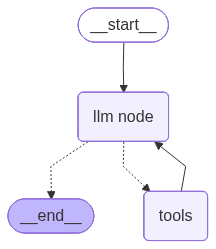

In [45]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def llm_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state.messages)
    messages = [response]
    new_state = State(messages=messages)
    return new_state

graph_builder.add_node("llm node", llm_node)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "llm node")
graph_builder.add_edge("llm node", END)
graph_builder.add_conditional_edges("llm node", tools_condition, "tools")
graph_builder.add_edge("tools", "llm node")

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


[22:54:09] You have a new notification!                                                             ]8;id=663108;file:///tmp/ipykernel_43240/2656331194.py\2656331194.py]8;;\:]8;id=763336;file:///tmp/ipykernel_43240/2656331194.py#5\5]8;;\

In [47]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [51]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

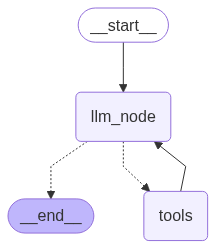

In [52]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools=tools)

def llm_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state.messages)
    messages = [response]
    new_state = State(messages=messages)
    return new_state


graph_builder.add_node("llm_node", llm_node)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "llm_node")
graph_builder.add_edge("llm_node", END)
graph_builder.add_conditional_edges("llm_node", tools_condition, "tools")
graph_builder.add_edge("tools", "llm_node")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_message, history):
    messages = [{"role": "user", "content": user_message}]
    state = State(messages=messages)
    new_state = graph.invoke(state, config=config)
    return new_state["messages"][-1].content

gr.ChatInterface(fn=chat, title="LangGraph LLM Test").launch()

/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.
